In [7]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import scipy
import sys
import os

from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split


_DATA_DIR = 'data'
_PEAJES_DATA_PATH = os.path.join(_DATA_DIR, '2014_data.csv')

In [8]:
print('Python version: {}\n'.format(sys.version))
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Scikit-Learn: ', sklearn.__version__)
print('Scipy: ', scipy.__version__)

Python version: 3.3.5 |Anaconda 2.2.0 (64-bit)| (default, Sep  2 2014, 13:55:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

Numpy:  1.9.2
Pandas:  0.16.0
Scikit-Learn:  0.15.2
Scipy:  0.15.1


## Reading the Data

Cargar los datos a un Pandas Data Frame. Solo voy a usar los datos del 2014 para entrenar el modelo:
 - Enero a Julio: Training and CV Data
 - Agosto: Me reservo unos datos para jugar con las predicciones

In [10]:
def load_data():
    df = pd.read_csv(_PEAJES_DATA_PATH, encoding = "utf-8", parse_dates=['fecha'])
    return df

df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131184 entries, 0 to 131183
Data columns (total 9 columns):
Unnamed: 0       131184 non-null int64
fecha            131184 non-null datetime64[ns]
dia              131184 non-null object
hora             131184 non-null object
horafin          131184 non-null object
estacion         131184 non-null object
tipovehiculo     131184 non-null object
formapago        131184 non-null object
cantidadpasos    131184 non-null int64
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 10.0+ MB


In [6]:
df.to_csv("./data/2014_data.csv")

## Data Cleaning

Voy a realizar un modelo simple, los datos que voy a utilizar para predecir son solamente:
 - Estacion de Peaje
 - Dia (Mes, Dia)
 - Hora

In [20]:
def clean_data(df):
    df['dia'] = df.dia.str.lower()
    # Setearle las Categorias y ordenarlas hace que los gráficos y los resumenes salgan más prolijos
    # Además sirve para que el get_dummies me devuelva bien independientemente de los valores del dataset
    df['dia'] = pd.Categorical(df.dia, categories=['domingo','lunes','martes','miércoles','jueves','viernes','sábado'], ordered=True)

    df['hora'] = df.hora.apply(lambda x: x.split(sep=':')[0]).astype('int')
    df['hora'] = df.hora

    df['horafin'] = df.horafin.apply(lambda x: x.split(sep=':')[0]).astype('int')
    df['horafin'] = df.horafin

    df['tipovehiculo'] = df.tipovehiculo.replace('Pesados', 'Pesado')
    df['tipovehiculo'] = df.tipovehiculo.replace('Livianos', 'Liviano')
    df['tipovehiculo'] = pd.Categorical(df.tipovehiculo, ordered=True)

    df['month'] = df.fecha.dt.month
    df['day'] = df.fecha.dt.day
    return df

df = clean_data(df)

In [21]:
df_agosto = df[df.month == 8]
df = df[df.month < 8]
#df = df.drop(['fecha', 'tipovehiculo', 'formapago', 'horafin','dia','month'], axis=1)

## Data Analysis

###### Cuantos autos pasan, en promedio, por unidad de peaje por hora?

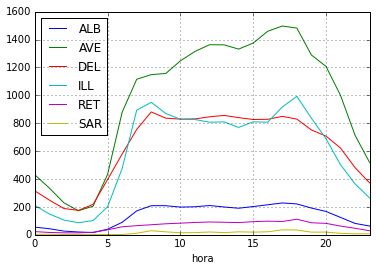

In [6]:
for key, group in df.groupby(by='estacion'):
    group.groupby('hora').cantidadpasos.mean().plot(legend=key, label=key)

##### Cuántos autos pasan, en promedio, por unidad de peaje por día?

## Data Preprocessing

### Encoding

In [7]:
def feature_encoding(df):
    y = df.cantidadpasos.astype(np.int)
    X = df.drop(['cantidadpasos'],axis=1)
    X = pd.get_dummies(X)
    #X = X.drop(['dia_domingo','estacion_SAR','tipovehiculo_Liviano','formapago_Aupass','month_3','day_11'],axis=1)
    return X.as_matrix(), y.as_matrix()

X, y = feature_encoding(df)

In [8]:
print('X: ', X.shape)
print('y: ', y.shape)
print("X: ", type(X))
print("y: ", type(y))

X:  (104916, 9)
y:  (104916,)
X:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>


### Predictions

In [147]:
def run_cross_validation(X, y, clf_class, **parameters):
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = np.zeros(len(y))
    
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier passed by parameter
        clf = clf_class(**parameters)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        
    return  clf, y_pred

In [10]:
decision_tree_model, decision_tree_pred = run_cross_validation(X,y,DecisionTreeRegressor)

print("Decision Tree Regressor R2 Score:", metrics.r2_score(y, decision_tree_pred))
print("Decision Tree Regressor MSE:", metrics.mean_squared_error(y, decision_tree_pred))

Decision Tree Regressor R2 Score: -0.263460764871
Decision Tree Regressor MSE: 1338745.71215


In [11]:
random_forest_model, random_forest_pred = run_cross_validation(X,y,RandomForestRegressor)
print("Random Forest R2 Score:", metrics.r2_score(y, random_forest_pred))
print("Random Forest MSE:", metrics.mean_squared_error(y, random_forest_pred))

Random Forest R2 Score: -0.262485513088
Random Forest MSE: 1337712.34872


In [12]:
gradient_boosting_model, gradient_boosting_pred = run_cross_validation(X,y,GradientBoostingRegressor)
print("Gradient Boosting Regressor R2 Score:", metrics.r2_score(y, gradient_boosting_pred ))
print("Gradient Boosting Regressor MSE:", metrics.mean_squared_error(y, gradient_boosting_pred))

Gradient Boosting Regressor R2 Score: 0.176196066393
Gradient Boosting Regressor MSE: 872891.358741


Segun los datos obtenidos en una primera pasada, **Gradient Boosting Regressor** tiene mucha mejor performance para los datos obtenidos. Pero qué tan buenos son? Vamos a hacer algunos cálculos con los datos reservados de Agosto y plotear algunos resultados:

### Predicción Agosto

In [13]:
X_agosto, y_agosto = feature_encoding(df_agosto)

In [14]:
print('X: ', X_agosto.shape)
print('y: ', y_agosto.shape)

X:  (26091, 9)
y:  (26091,)


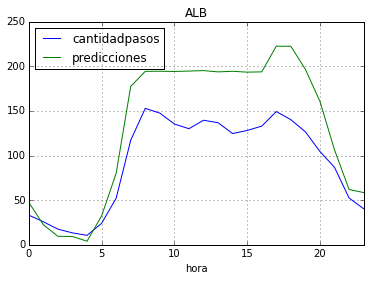

In [185]:
df_agosto['predicciones'] = gradient_boosting_model.predict(X_agosto)
for key, group in df_agosto.groupby('estacion'):
    plt.figure()
    group.groupby('hora').cantidadpasos.mean().plot(title=key, legend='cantidadpasos')
    group.groupby('hora').predicciones.mean().plot(legend='predicciones')
    break # Sacar el Break para plotear todas las estaciones

Bueno, vemos que las predicciones no son muy buenas. Despues de investigar un poco en la página oficial de Scikit Learn llegamos a las siguientes conclusiones y acciones:
 - Los métodos de regresión basados en árboles son muy influenciados por Outliers
 - GBR provee varios nucleos que pueden hacerlo más robusto frente a datos con muchos Outliers
 - Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
 
Acciones:
 - Revisar outliers en los datos de entrenamiento y eliminar  de haber mucha presencia
 - Utilizar distintas funciones loss para ver cual obtiene mejor performance

##### Plot de outliers

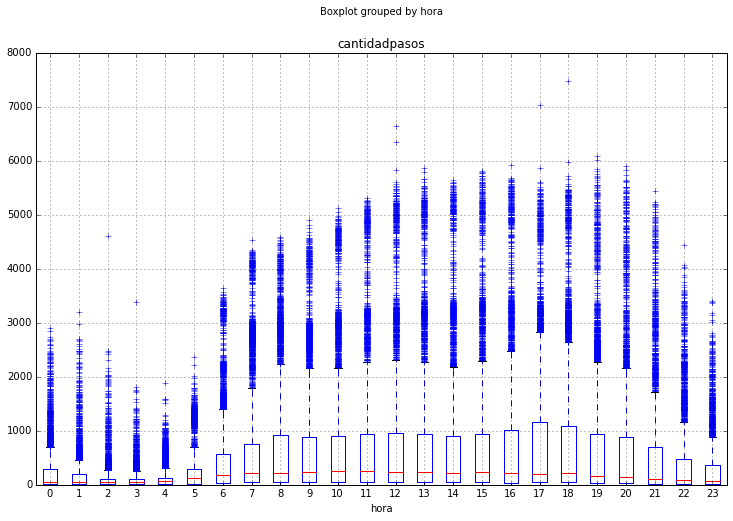

In [143]:
df.boxplot(column='cantidadpasos', by='hora', figsize=(12,8))

Vemos que hay una fuerte prescencia de Outliers en los datos. Vamos a eliminar un poco y hay muchos criterios:
 - Eliminar valores altos
 - Eliminar valores altos teniendo en referencia los valores altos de cada estacion
 - Eliminar valores altos teniendo en referencia los valores altos de cada estación y cada hora
Vamos por el más simple: **Eliminar valores altos**

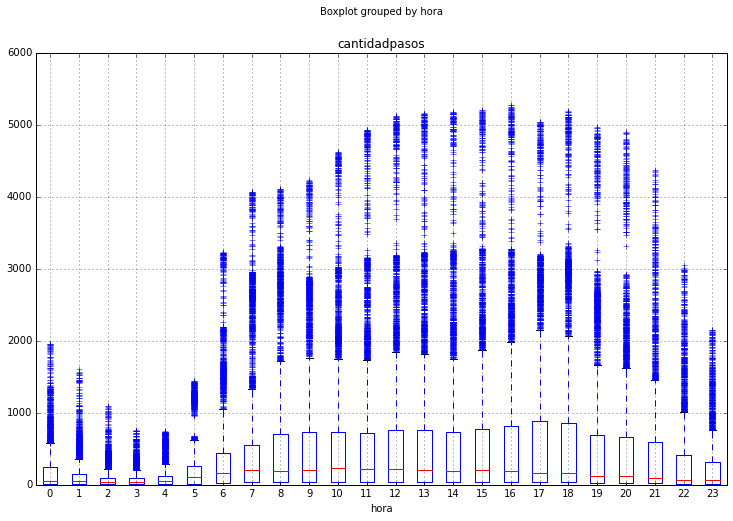

In [144]:
for estacion, group in df.groupby(by=['estacion','hora']):
    q = group.cantidadpasos.quantile(q=0.95)
    outliers = df[(df.estacion == estacion[0]) & (df.hora == estacion[1]) & (df.cantidadpasos > q)].index
    df = df.drop(outliers)

df.boxplot(column='cantidadpasos', by='hora', figsize=(12,8))

Vamos a Probar ahora con menox outliers y el nucleo 'huber'

In [166]:
X, y = feature_encoding(df)

parameters = {'n_estimators': 750}
gradient_boosting_model, gradient_boosting_pred = run_cross_validation(X, y, GradientBoostingRegressor, **parameters)
print("Gradient Boosting Regressor R2 Score:", metrics.r2_score(y, gradient_boosting_pred ))
print("Gradient Boosting Regressor MSE:", metrics.mean_squared_error(y, gradient_boosting_pred))

Gradient Boosting Regressor R2 Score: 0.173811860316
Gradient Boosting Regressor MSE: 656744.337884


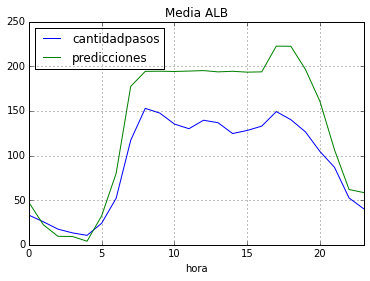

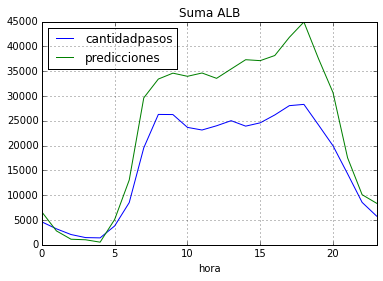

In [184]:
df_agosto['predicciones'] = gradient_boosting_model.predict(X_agosto)
for key, group in df_agosto.groupby('estacion'):
    plt.figure()
    group.groupby('hora').cantidadpasos.mean().plot(title="Media " + key, legend='cantidadpasos')
    group.groupby('hora').predicciones.mean().plot(legend='predicciones')
    plt.figure()
    group.groupby('hora').cantidadpasos.sum().plot(title="Suma " + key, legend='cantidadpasos')
    group.groupby('hora').predicciones.sum().plot(legend='predicciones')
    break # Sacar el Break para plotear todas las estaciones

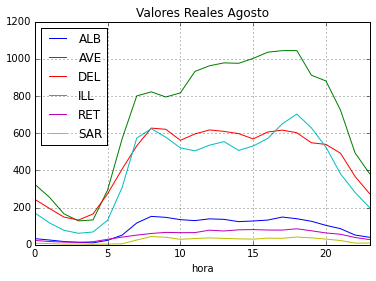

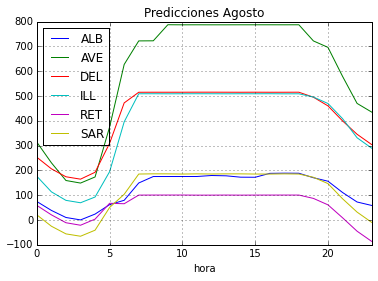

In [183]:
for key, group in df_agosto.groupby(by='estacion'):
    group.groupby('hora').cantidadpasos.mean().plot(title='Valores Reales Agosto', legend=key, label=key)

plt.figure()
for key, group in df_agosto.groupby(by='estacion'):
    group.groupby('hora').predicciones.mean().plot(title='Predicciones Agosto', legend=key, label=key)

Se me ocurrió que quizá si entrene también con datos de agosto esa brecha se reduzca un poco.

In [209]:
df = load_data()
df = clean_data(df)

df_agosto = df[(df.month == 8) & (df.day > 21)]
df = df.query('month < 8 | (month == 8 & day < 21)')

X, y = feature_encoding(df)
print(X.shape)
print(y.shape)
print("X: ", type(X))
print("y: ", type(y))

(121788, 9)
(121788,)
X:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>


In [210]:
parameters = {'n_estimators': 750}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

clf = GradientBoostingRegressor(**parameters)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Gradient Boosting Regressor R2 Score:", metrics.r2_score(y_test, y_pred ))
print("Gradient Boosting Regressor MSE:", metrics.mean_squared_error(y_test, y_pred))

Gradient Boosting Regressor R2 Score: 0.177394880421
Gradient Boosting Regressor MSE: 823986.283355


(121788, 9)
(121788,)
X:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>


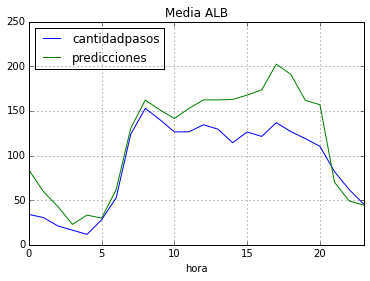

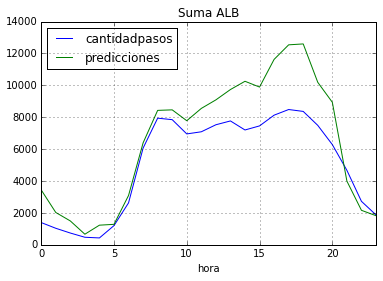

In [215]:
X_agosto, y_agosto = feature_encoding(df_agosto)
print(X.shape)
print(y.shape)
print("X: ", type(X))
print("y: ", type(y))
df_agosto['predicciones'] = clf.predict(X_agosto)
for key, group in df_agosto.groupby('estacion'):
    plt.figure()
    group.groupby('hora').cantidadpasos.mean().plot(title="Media " + key, legend='cantidadpasos')
    group.groupby('hora').predicciones.mean().plot(legend='predicciones')
    plt.figure()
    group.groupby('hora').cantidadpasos.sum().plot(title="Suma " + key, legend='cantidadpasos')
    group.groupby('hora').predicciones.sum().plot(legend='predicciones')
    break # Sacar el Break para plotear todas las estaciones

##### Probar distintos Kernels para GradientBoostingRegressor

Ahora ejecutamos y esperamos... :)

In [23]:
X_cleaned, y_cleaned = feature_encoding(df)

parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'n_estimators': [10, 100, 250, 500],
              'learning_rate': [0.01, 0.03, 0.1, 0.3, 1, 3]}

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.1)

optimized_gradient_boosting_model = GradientBoostingRegressor()
regressor = GridSearchCV(optimized_gradient_boosting_model, parameters)
regressor.fit(X_train, y_train)


GridSearchCV(cv=None,
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 250, 500], 'learning_rate': [0.01, 0.03, 0.1, 0.3, 1, 3], 'loss': ['ls', 'lad', 'huber', 'quantile']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [24]:
# {'learning_rate': 0.1, 'n_estimators': 500, 'loss': 'ls'}
print(regressor.best_params_)
print("Gradient Boosting Regressor R2 Score:", metrics.r2_score(y_test, regressor.predict(X_test) ))
print("Gradient Boosting Regressor MSE:", metrics.mean_squared_error(y_test, regressor.predict(X_test)))

{'learning_rate': 0.1, 'n_estimators': 500, 'loss': 'ls'}
Gradient Boosting Regressor R2 Score: 0.135955469476
Gradient Boosting Regressor MSE: 385682.176179


### Post Features Importance

In [268]:
df = df.drop('dia',axis=1)

In [275]:
df_agosto = df_agosto.drop('dia',axis=1)
df_agosto = df_agosto.drop('predicciones',axis=1)

In [271]:
X, y = feature_encoding(df)

In [272]:
random_forest2 = predict_random_forest(X, y, **parameters_rfr)

Mean Square Error: 60136.073
R2 Score: 0.944


In [276]:
X_agosto, y_agosto = feature_encoding(df_agosto)
df_agosto['predicciones'] = random_forest2.predict(X_agosto)

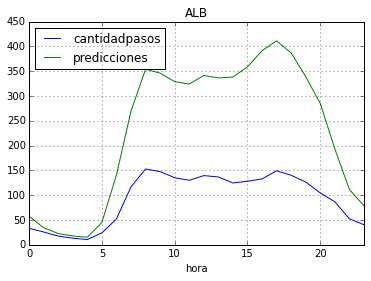

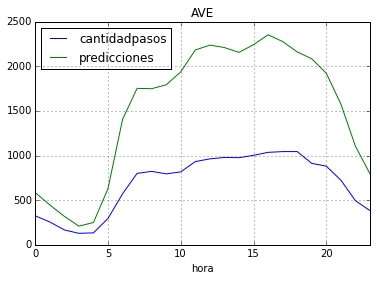

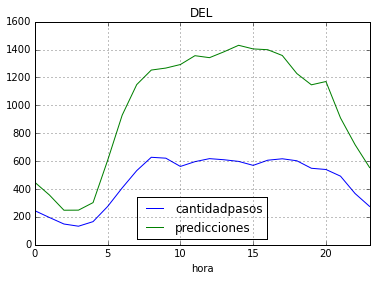

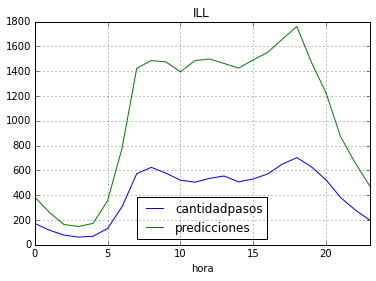

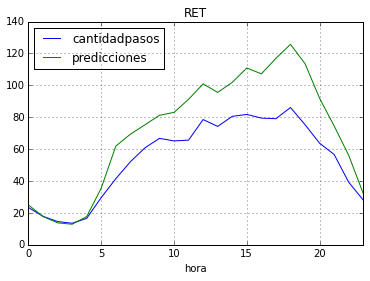

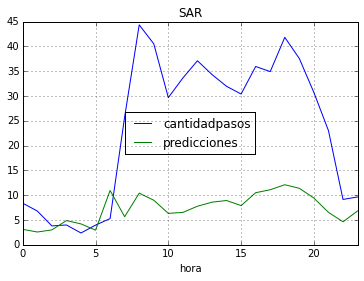

In [277]:
for key, group in df_agosto.groupby('estacion'):
    plt.figure()
    group.groupby('hora').cantidadpasos.mean().plot(title=key, legend='cantidadpasos')
    group.groupby('hora').predicciones.mean().plot(legend='predicciones')

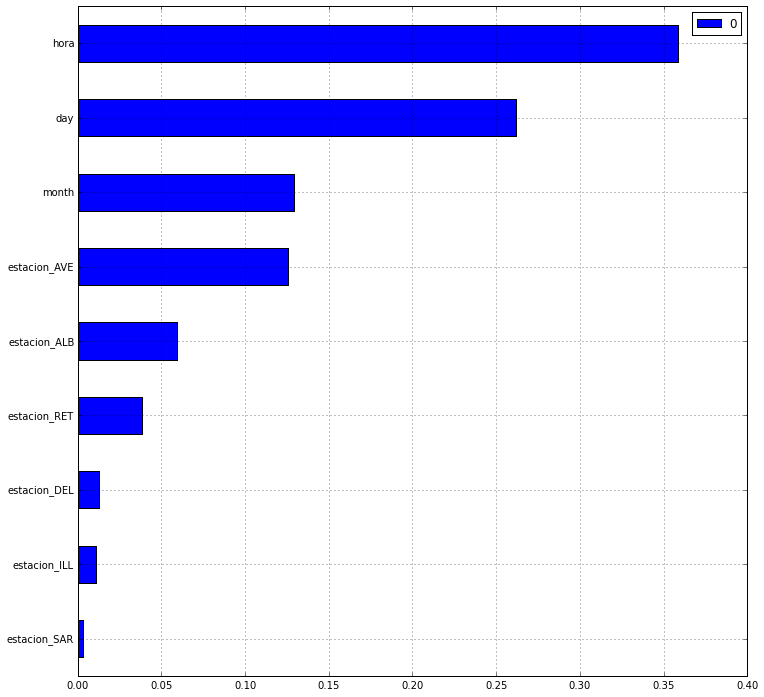

In [18]:
pd.DataFrame(random_forest.feature_importances_, index = X.columns).sort(0,ascending=True).plot(kind='barh', figsize=(12,12))